# Question 1 - Alex Bercik (1002128020) and Jaewon Yun (999243322)

In [1]:
# Import modules
from random import random,randrange
from math import exp,pi,sqrt
from numpy import ones,empty,histogram,array
from pylab import plot,ylabel,xlabel,title,show,figure, \
                    bar,axhline,legend,grid
from scipy.optimize import curve_fit

# Part A) Monte Carlo Simulation of an Ideal Gas

Here we employ a Monte Carlo simulation using a Metropilis algorithm Markov Chain to simulate an ideal gas in a box. We refer the reader to Newman for a discussion for the derivation of this method. Here I summarize the basic steps:

1. Choose a starting state (here ground state)

2. Choose a move from $i$ to $j$ randomly from a set of allowed moves (here modifying one quantum number)

3. Calculate the $\textit{acceptance probability}$ $$ P_a = \begin{cases} 1 & \text{if} \;\; E_j \leq E_i \\ e^{-\beta (E_j - E_i)} & \text{if} \;\; E_j > E_i \end{cases} $$

4. According to the probability, either accept or reject the move

5. Measure the quantity of interest (here Energy $E$) and add it to a running sum

6. Repeat from step 2

For the ideal gas, we assume Energy takes the simple form
\begin{equation*}
E=\sum_{i=1}^N E(n_x^{(i)},n_y^{(i)},n_z^{(i)}) \quad \text{where} \quad E(n_x,n_y,n_z) = \frac{\pi^2 \hbar^2}{2mL^2}(n_x^2+n_y^2+n_z^2)
\end{equation*}
and $n_i = 1,2,\dotsc,\infty$ are the quantum numbers that we will step through in increments of $1$. It can be shown easily that the change in energy through stepping $n_i \rightarrow n_i + 1$ is given by:
\begin{equation*}
\Delta E = \frac{\pi^2 \hbar^2}{2mL^2}(-2n_i +1)
\end{equation*}

Below we take the code $\texttt{mcsim.py}$ from Newman and modify it as required. We are working in units where $m=\hbar=1$ and set $L=1$.

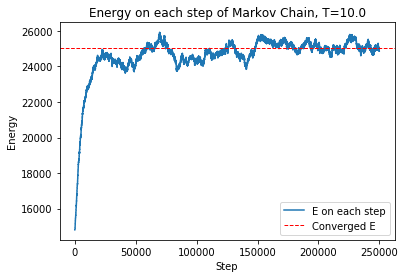

In [2]:
def simulation(T,N,steps):
    ''' Function to call the Monte Carlo simulation for Quantum Gas.
    INPUTS: Temperature, Number of Particles, Number of Steps
    OUTPUTS: eplot (array of energies as fn of steps),
             n (Nx3 array of quantum numbers)'''
    # Create a 2D array to store the quantum numbers
    n = ones([N,3],int) # start in ground state (all n=1)
    eplot = empty(steps) # initialize array to store energies
    E = 3*N*pi*pi/2 # set initial energy (here ground state)
    
    for k in range(steps):
        # Choose the particle and the move
        i = randrange(N)
        j = randrange(3)
        if random()<0.5: # 50% chance to increase n_i
            dn = 1
            dE = (2*n[i,j]+1)*pi*pi/2
        else: # 50% chance to decrease n_i
            dn = -1
            dE = (-2*n[i,j]+1)*pi*pi/2

        # Decide whether to accept the move
        if n[i,j]>1 or dn==1:
            if random()<exp(-dE/T): # if falls in acceptance prob.
                n[i,j] += dn # modify n_i
                E += dE # modify E
    
        eplot[k] = E # append E value for step to E array
    return(eplot,n)

def makeplot(eplot,steps,step_cvg,T):
    '''Plot the energies calculated in simulation against steps
    INPUTS: eplot array, total number of steps, number of steps requiered 
            to converge E, temperature.'''
    # Make the graph
    plot(eplot,label='E on each step')
    ylabel("Energy")
    xlabel("Step")
    title("Energy on each step of Markov Chain, T={0}".format(T))
    # also plot the converged energy, averaging final steps-step_cvg steps
    avgE = sum(eplot[step_cvg:])/(steps-step_cvg)
    axhline(avgE,linestyle='--',linewidth=1,color='r',label='Converged E')
    legend()
    show()
    
T = 10.0 # set temperature k*T = 10
N = 1000 # set number of gas particles
steps = 250000 # set number of Markov Chain steps
step_cvg = 100000 # assume E converges after this many steps

eplot_a , n_a = simulation(T,N,steps) # perform simulation
makeplot(eplot_a,steps,step_cvg,T) # make plot

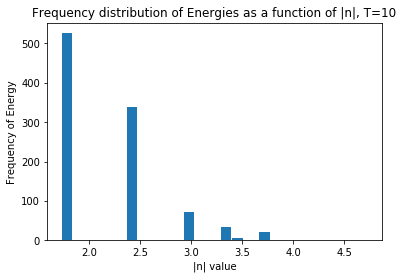

In [7]:
def computehistogram(n):
    '''Calculate a histogram of the normalized energies
    INPUT: n (Nx3 array of quantum numbers)
    OUTPUT: frequencies of energies, n value corresponding to energy'''
    # Calculate the energy of each particle, without constant factors
    energy_n = n[:,0]**2 + n[:,1]**2 + n[:,2]**2

    # bin the n energies ino 50 bins into a histogram
    # the counts in each bin are the frequency distribution
    energy_frequency,bins = histogram(energy_n, 50)

    # instead of taking the edge value of the bins, we want to plot
    # against the central energy value
    energy_vals = 0.5*(bins[:-1] + bins[1:])

    # take square root to recover n value from energy vals (no mult. factors)
    n_vals = energy_vals**0.5
    return(n_vals, energy_frequency)

n_vals, energy_frequency = computehistogram(n_a) # get histogram values

# Create the desired plot
figure()
ylabel("Frequency of Energy")
xlabel("|n| value")
title("Frequency distribution of Energies as a function of |n|, T=10")
bar(n_vals, energy_frequency, width=0.1)
show()

The above frequency distribution is plotted for the last step in our markov chain, a randomly chosen state when it is near thermal equilibrium. It shows the number of states with each particular energy, conveniently labelled by $n=\sqrt{n_x^2+n_y^2+n_z^2}$. We find (unsurprisingly) that at this relatively low but non-zero temperature, the majority of the particles remain in their ground state with $n_x=n_y=n_z=1$, while a noticeable amount are in the first excited state, where only one $n_i = 2$. The higher excited states make up a minority of the particles in the box, as expected by statistical mechanics.

# Part B) Testing different temperatures

We now want to calculate the average value of $n$ for the system after it reaches an equilibrium for a variety of different intitial $T$'s. To do this, we will run the simulations with sufficient steps such that they converge to an energy $E$, and then analyze the $n$ distributions among particles at the final random step (just like in part a). The average $n$ of the particles can be approximated with
\begin{equation*}
\overline { n } \approx \frac { \sum _ { n } f \left( e _ { n } \right) n } { \sum _ { n } f \left( e _ { n } \right) }.
\end{equation*}

where $e_n$ is the normalized energy we used in Part (a) for the histogram, and $f(e_n)$ is the frequency, or number of particles with that $e_n$ value. Once calculated, we will then plot total energy $E(T)$ and $\overline { n }(T)$ for values $k_BT = 10, 40, 100, 400, 1200, 1600.$ We will use the code above first for each temperature to ensure that each run has converged to a particular energy correctly before proceeding. We expect that each temperature will require a different number of steps.

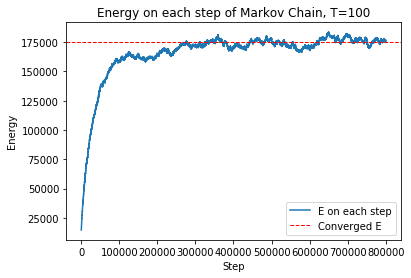

In [4]:
# Code used to test various values of T, steps, step_cvg. Try it!
N=1000
T=100
steps=800000
step_cvg=400000

makeplot(simulation(T,N,steps)[0],steps,step_cvg,T)

This next part was done by trial and error (I will not show all the plots here), but the required number of steps was found for each temperature by calling the following single function and changing the arguments until the energy $E$ visibly converged.

$$\texttt{makeplot(simulation(T,N,steps)[0],steps,step\_cvg,T)}$$

The results are summarized in the table below: ($\texttt{steps}$ is the total amount of steps used, and $\texttt{step\_cvg}$ is the ballpark eyeball estimate for when the $E$ is converged, based on the graph.

| **Temperature** | **steps** | **step_cvg** |
| :---: | :---: | :---: |
| 10 | 250,000 | 100,000 |
| 40 | 400,000 | 200,000 |
| 100 | 800,000 | 400,000 |
| 400 | 2,000,000 | 1,400,000 |
| 1200 | 6,000,000 | 4,000,000 |
| 1600 | 7,000,000 | 5,000,000 |

<!---  NOTE: INCLUDE THIS AND IGNORE ABOVE FOR PDF CONVERSION
 

\begin{tabular}{ c | c | c}			
  \textbf{Temperature} & \textbf{steps} & \textbf{step\_cvg} \\
  \hline
  10 & 250,000 & 100,000 \\
  40 & 400,000 & 200,000 \\
  100 & 800,000 & 400,000 \\
  400 & 2,000,000 & 1,400,000 \\
  1200 & 6,000,000 & 4,000,000 \\
  1600 & 7,000,000 & 5,000,000 
\end{tabular} ---> 

We noted in our experiment that for higher temperatures, the fluctuations around the converged $E$ were larger, so not only were more steps required to converge to an area around $E$, but a longer convergence time is needed after to be able to calculate an average converged $\overline{E}$

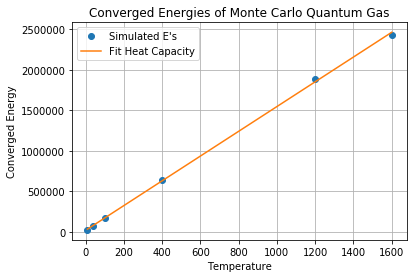

Calculated Heat Capacity Δ E / Δ t = 1528 +- 15)


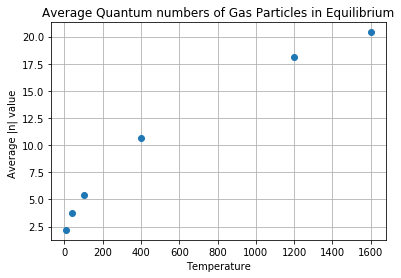

In [6]:
# store data from above table into lists
temps = [10,40,100,400,1200,1600]
Steps = [250000,400000,800000,2000000,6000000,7000000]
Steps_cvg = [100000,200000,400000,1400000,4000000,5000000]
energies = [] # list to store converged energies for all t
avg_n = [] # list to store average n for all t (equation above)

for i in range(len(temps)): # Loop to do calculations for each t
    # get variables so that we don't always have to call index
    t,step,step_cvg = temps[i],Steps[i],Steps_cvg[i]
    
    eplot, n = simulation(t,N,step) # perform simulation
    E = sum(eplot[step_cvg:])/(step-step_cvg) # get converged E
    n_vals, e_freq = computehistogram(n) # get histogram values
    
    # calculate average n according to equation above
    navg = sum(e_freq*n_vals)/sum(e_freq)
    
    energies.append(E) # append converged E to energies list
    avg_n.append(navg) # append average n to list

# Create a plot of Converged Energies as a function of Temperature
# also do a linear fit using scipy to estimate heat capacity
def f(x,a,b): # use a linear fit to model heat capacity
    return b*x + a
p_opt, p_cov = curve_fit(f, temps, energies, (1,1))
fit = f(array(temps),*p_opt)

figure() # Plot converged energies as a function of temperature
ylabel("Converged Energy")
xlabel("Temperature")
title("Converged Energies of Monte Carlo Quantum Gas")
plot(temps,energies,'o',label="Simulated E's")
plot(temps,fit,'-',label='Fit Heat Capacity')
legend()
grid()
show()

#output calculated slope of fit, i.e. heat capacity E/t
hcap = p_opt[1]
hcap_unc = sqrt(p_cov[1,1])
print("Calculated Heat Capacity \u0394 E / \u0394 t = " + 
        "{0} +- {1})".format(int(hcap),int(hcap_unc)))

figure() # Plot average quantum number as a function of temperature
ylabel("Average |n| value ")
xlabel("Temperature")
title("Average Quantum numbers of Gas Particles in Equilibrium")
plot(temps,avg_n,'o')
grid()
show()

We have succesfully performed a statistical mechanics simulation of an ideal quantum gas using a Monte Carlo Metropolis chain. In Part (a) we ran a simulated 1000 particles at a temperature of $k_BT=10$, and let the simulation run until it reached an equilibrium temperature. Once at an equilibrium temperature , we plotted the energy distribution of the particles in a histogram (distribution of average $n$ value). In Part (b), we used this same code to explore a variety of different temperatures. We first determined the necessary number of steps to reach equilibrium at each temperature, and then cycled through the same calculations as in Part (a) for each temperature. At the end, we were able to plot the converged energy (taken as an average $\overline{E}$ over many steps once converged) against temperature and estimate a heat capacity from the relationship $\Delta E / \Delta T$. We estimated this from the slope of the graph, which we in turn calculated using the $\texttt{scipy.optimize}$ package. Our calculated value was around $\Delta E / \Delta T \approx 1530$. Finally, we used the same histogram code from Part (a) to find the $n$ distributions for each temperature, and find an average $\overline{n}$ from the formula shown at the begining of the section. This allowed us to plot the average $\overline{n}$ for each temperature and derive a relationship from the graph.

We can conclude that for an ideal quatum gas, the energy scales linearly with temperature (where in our units we find $\Delta E / \Delta T \approx 1530$) and the average quantum number $\overline{n}$ of the particles scales as $\sqrt{T}$ with temperature. This is precisely the behaviour predicted by theory.